# Training a regression

Train a single variable to discriminate between input and outputs where the variable is a 1 or a zero - so this is a regression. This is a step along the way to training two variables.

## Settings

In [1]:
n_variables = 4 # Number of data and background varialbes to generate
n_samples = 10000 # Number of samples to generate

center_signal = 2.0 # Where the gaussian for signal should be
center_background = 1.0 # Where the gaussian for background should be

In [2]:
import sys
sys.path += ['../abcdlib']
import data_gen

import seaborn as sns
import pandas as pd
from torch import nn
from torch import optim
import torch
import torch.nn.functional as nnf

## Generate the data

In [3]:
sig = data_gen.generate_gaussian(n_variables, center_signal, n_samples)
back = data_gen.generate_gaussian(n_variables, center_background, n_samples)

half = int(n_samples/2)

training = data_gen.combine(sig[:half], back[:half])
testing = data_gen.combine(sig[half:], back[half:])

## Train with one output

For a regression, we need just a single output column with the 1 or 0 as the target value.

In [4]:
training[training.columns[-1]].values.reshape(-1,1).shape

(10000, 1)

In [5]:
x_train = torch.Tensor(training[training.columns[:-1]].values)
y_train = torch.Tensor(training[training.columns[-1]].values.reshape(-1,1))

Next create a simple classifier - 2 layers, with the same number of nodes as inputs. It looks like doubling the size of the inputs and outputs makes a big difference, but in general getting this to train better hasn't been successful so far. No idea why.

In [6]:
model = nn.Sequential(nn.Linear(n_variables, n_variables*2),
                      nn.ReLU(),
                      nn.Linear(n_variables*2, n_variables),
                      nn.ReLU(),
                      nn.Linear(n_variables, 1))
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

Now lets do the training

In [7]:
epochs = 1000
for e in range(epochs):
    running_loss = 0
    optimizer.zero_grad()
    output = model(x_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
else:
    print(f'Training loss: {running_loss/len(x_train)}')

Training loss: 1.1816892027854919e-05


## Prediction

Get the predicted probabilities out and see where they line up and how well this guy did!

In [8]:
x_test = torch.Tensor(testing[testing.columns[:-1]].values)
y_test = model(x_test)

In [9]:
x_results = testing.copy()
x_results['Prediction'] = y_test.detach().numpy()[:,0]

<AxesSubplot:xlabel='Prediction', ylabel='Count'>

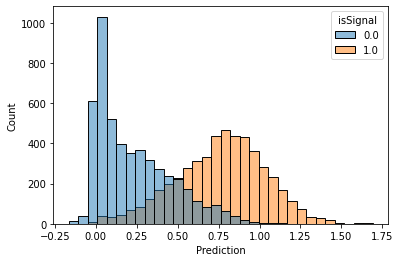

In [10]:
sns.histplot(x_results, x='Prediction', hue='isSignal')